Star-Dia Source Correlation
===

The goal of this notebook is to understand the distribution of Dia sources surrounding bright stars. The input to this is the output from `star_diffim_correlation.py`, which produces an sqlite3 file containing sets of the radii of each Dia source surrounding stars brighter than ~16 (really anything in the UCAC catalog).

In [1]:
%matplotlib inline
from __future__ import print_function, division

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import sqlalchemy
from sqlalchemy.orm import sessionmaker

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

from star_diffim_correlation import SourceDetectionCorrelation as SDC

In [2]:
engine = sqlalchemy.create_engine('sqlite:///star_diffim.sqlite3')

SessionFactory = sessionmaker()
SessionFactory.configure(bind=engine)
session = SessionFactory()

In [6]:
def make_normalized_histogram(filtered_query, bins):
    H = np.zeros(len(bins) - 1)
    for source in filtered_query:
        source_H, _ = np.histogram(source.dist_array(), bins=bins)
        H += source_H
        
    nstars = filtered_query.count()
    norm = np.pi*bins[1:]**2 - np.pi*bins[:-1]**2
    normalized_H = H/norm/float(nstars)
    return normalized_H


This next code computes the Dia source density histograms in bins of (bright source) magnitude. It is somewhat slow, so it is separated from plotting. Output is in `density_curves`.

In [21]:
radius_bins = np.linspace(0,120,60)
radius_bin_centers = 0.5*(radius_bins[1:] + radius_bins[:-1])

# 60 chips. 0.045 sq deg per chip. 3600**2 sq arcsec per sq deg
# 20e3 detections is what I get from counting on visit 197391
mean_density = 0.3*20e3 / (60 * 0.045) / 3600.0**2

# All the good visits happen to be < 197800
good_visits =  (197367, 197375, 197379, 197388, 197392, 197400, 197404, 197412)

density_bins = [16,15,14,13,12,10,8]
density_curves = []
for bin_start,bin_end in zip(density_bins[:-1], density_bins[1:]):
    filtered_query = session.query(SDC).filter((SDC.visit < 197801) &
                                               (SDC.source_mag < bin_start) &
                                               (SDC.source_mag > bin_end))
    normalized_H = make_normalized_histogram(filtered_query, radius_bins)
    density_curves.append(normalized_H/mean_density)
    

Now we can plot the results in `density_curves`, and test out a trial functional form to fit to it.

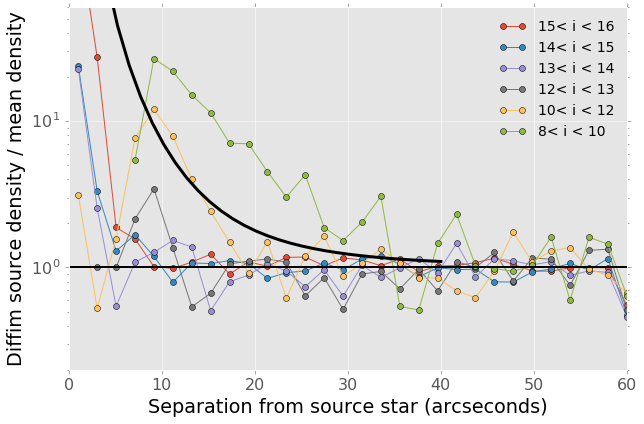

In [55]:

for bin_start,bin_end,curve_values in zip(density_bins[:-1], density_bins[1:], density_curves):
    plt.semilogy(radius_bin_centers, curve_values, 'o-',
             label="{:d}< i < {:d}".format(bin_end, bin_start))

plt.axhline(1, color='k', ls='-', lw=2)
plt.ylim(0.2,60)
plt.xlim(0,60)
plt.xlabel("Separation from source star (arcseconds)")
plt.ylabel("Diffim source density / mean density")
plt.legend(frameon=False, loc="upper right", fontsize=14)
x = np.linspace(4,40,30)
plt.plot(x, 1 + 7*30*30*(x )**-3, 'k-', lw=3)

To fit this set of curves, I need a function for how they scale with source magnitude. I estimate this by plotting the radius at which the dia source density is twice the mean density, for each magnitude bin.

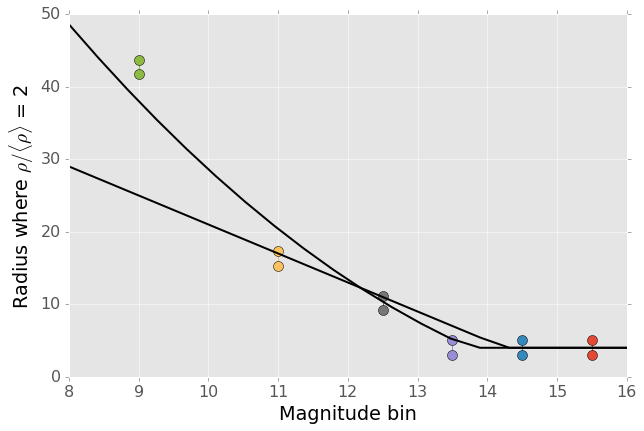

In [42]:
for bin_start,bin_end,curve_values in zip(density_bins[:-1], density_bins[1:], density_curves):
    bin_center = 0.5*(bin_start + bin_end)
    sel_gt_2 = np.where(curve_values > 2)
    sel = np.max(sel_gt_2),(np.max(sel_gt_2)+1)
    bounds_gt_2 = curve_values[np.max(sel_gt_2):(np.max(sel_gt_2)+2)]
    #plt.plot(bin_center + np.zeros(2), bounds_gt_2, 'o-')
    plt.plot(bin_center + np.zeros(2),
             radius_bin_centers[np.max(sel_gt_2):(np.max(sel_gt_2)+2)], 'o-', ms=10)

x = np.linspace(8,16,20)

# Original
plt.plot(x, np.maximum(13-4*(x-12), 4), 'k-', lw=2)

plt.plot(x, np.maximum(11-4*(x-12) + 0.6*(x-14)**2, 4), 'k-', lw=2)

plt.xlim(8,16)
plt.xlabel("Magnitude bin")
plt.ylabel(r"Radius where $\rho/\langle\rho\rangle$ = 2")

This looks ok; a linear scaling with magnitude seems reasonable. Now we can plot one curve for each magnitude bin and the data too.

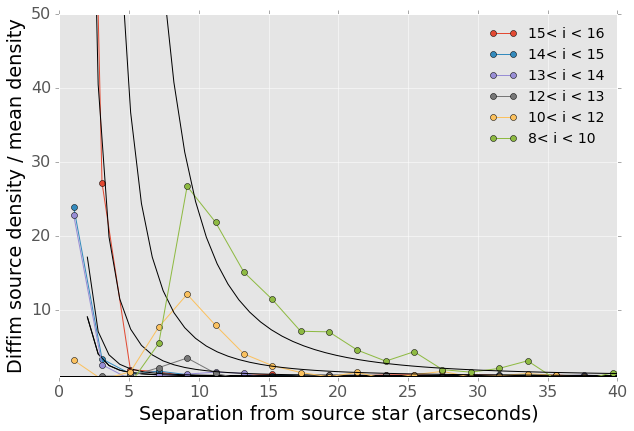

In [56]:
for bin_start,bin_end,curve_values in zip(density_bins[:-1], density_bins[1:], density_curves):
    plt.plot(radius_bin_centers, curve_values, 'o-',
             label="{:d}< i < {:d}".format(bin_end, bin_start))
    mag_bin_center = 0.5*(bin_start + bin_end)
    x = np.linspace(2,40,50)
#    radius_normalization = np.maximum(12-4*(mag_bin_center-12), 4)
    radius_normalization = np.maximum(11-4*(mag_bin_center-12) + 0.2*(mag_bin_center-14)**2, 4)

    plt.plot(x, 1 + (x )**-3.0 / (radius_normalization**-3.0), 'k-', lw=1)

plt.axhline(1, color='k', ls='-', lw=1)
plt.ylim(0.9,50)
plt.xlim(0,40)
plt.xlabel("Separation from source star (arcseconds)")
plt.ylabel("Diffim source density / mean density")
plt.legend(frameon=False, loc="upper right", fontsize=14)


This also looks quite good, at least at capturing the rise at large radii. To summarize, the model curves are:

$$\rho / \langle \rho \rangle = 1 + (r/r_{norm})^{-3.5},$$
$$r_{norm} = max(13.4 - 4(M - 12), 4) \,\rm{arcsec}$$

The behavior at small radii for bright sources is broken, because at some point the footprint for the bright star will prevent detection of difference sources. As an attempt to get at that behavior, I'll plot the nearest dia source to each bright star, and try to extract some scaling.

Cumulative distribution
------

In [175]:
radius_bins = np.linspace(0,60,60)
radius_bin_centers = 0.5*(radius_bins[1:] + radius_bins[:-1])

# 60 chips. 0.045 sq deg per chip. 3600**2 sq arcsec per sq deg
# 20e3 detections is what I get from counting on visit 197391
mean_density = 0.3*20e3 / (60 * 0.045) / 3600.0**2

# All the good visits happen to be < 197800
good_visits =  (197367, 197375, 197379, 197388, 197392, 197400, 197404, 197412)

#density_bins = [14,12,10,8]
density_bins = [14,13,12,11,10,9,8]
cumulative_curves = []
cumulative_curves_reversed = []
for bin_start,bin_end in zip(density_bins[:-1], density_bins[1:]):
    filtered_query = session.query(SDC).filter((SDC.visit <= max(good_visits)) &
                                               (SDC.source_mag < bin_start) &
                                               (SDC.source_mag > bin_end))
    H_cumulative = np.zeros(len(radius_bins) - 1)
    H_reversed = np.zeros(len(radius_bins) - 1)

    for source in filtered_query:
        source_H, _ = np.histogram(source.dist_array(), bins=radius_bins)
        H_cumulative += np.cumsum(source_H)
        H_reversed += np.cumsum(source_H[::-1])[::-1]
        
    cumulative_curves.append(H_cumulative/float(filtered_query.count()))
    cumulative_curves_reversed.append(H_reversed/float(filtered_query.count()))

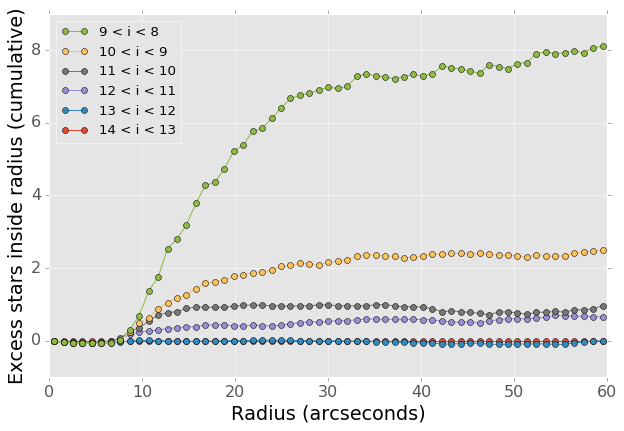

In [186]:
for n,curve in enumerate(cumulative_curves):
    plt.plot(radius_bin_centers, curve - cumulative_curves[0], '-o',
             label="{:.0f} < i < {:.0f}".format(density_bins[n],density_bins[n+1]))

handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::-1], labels[::-1], fontsize="small", loc=0)

plt.xlabel("Radius (arcseconds)")
plt.ylabel("Excess stars inside radius (cumulative)")

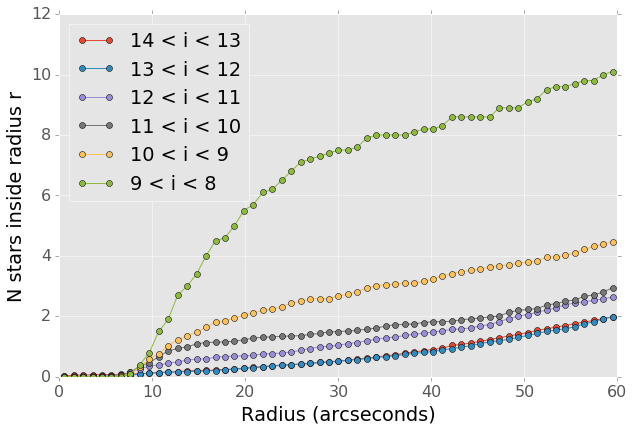

In [178]:
for n,curve in enumerate(cumulative_curves):
    norm = 1
    #norm = 1/curve[len(curve)/2]

    plt.plot(radius_bin_centers, norm*curve, '-o',
             label="{:.0f} < i < {:.0f}".format(density_bins[n],density_bins[n+1]))

plt.legend(loc=0)
plt.xlabel("Radius (arcseconds)")
plt.ylabel("N stars inside radius r")

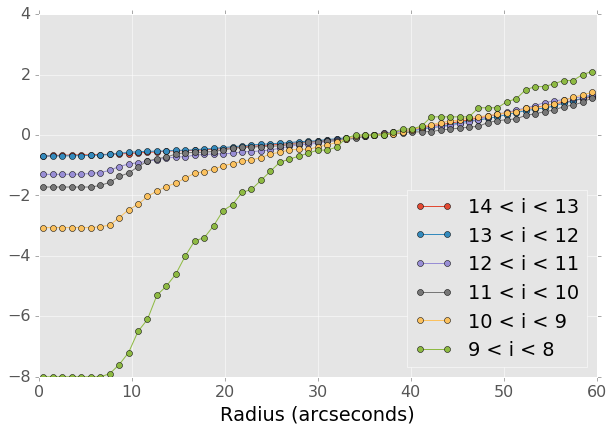

In [179]:
for n,curve in enumerate(cumulative_curves):
    plt.plot(radius_bin_centers, norm*curve - curve[int(0.6*len(curve))], '-o',
             label="{:.0f} < i < {:.0f}".format(density_bins[n],density_bins[n+1]))
plt.legend(loc=0)
plt.xlabel("Radius (arcseconds)")

Inner edge
-----

In [8]:
min_det_source_mags = []
min_det_dists = []
for source in session.query(SDC).filter(SDC.detection_dists != None,
                                        SDC.source_mag < 14,
                                        SDC.source_mag > 8):
    min_det_source_mags.append(source.source_mag)
    min_det_dists.append(np.min(source.dist_array()))

min_det_source_mags = np.array(min_det_source_mags)
min_det_dists = np.array(min_det_dists)

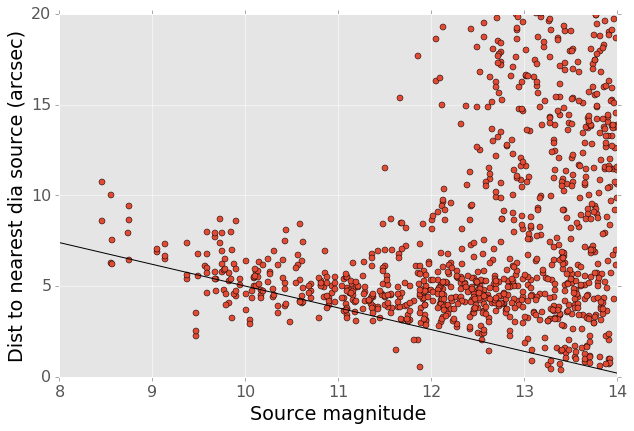

In [9]:
plt.plot(min_det_source_mags, min_det_dists, 'o')
x = linspace(8,14)
plt.plot(x, 5 + -1.2*(x-10), 'k-')
plt.ylim(0,20)
plt.xlabel("Source magnitude")
plt.ylabel("Dist to nearest dia source (arcsec)")

Now just inventing a "completeness" function to apply to the dia source curves. This is totally made up, just to see if it works.

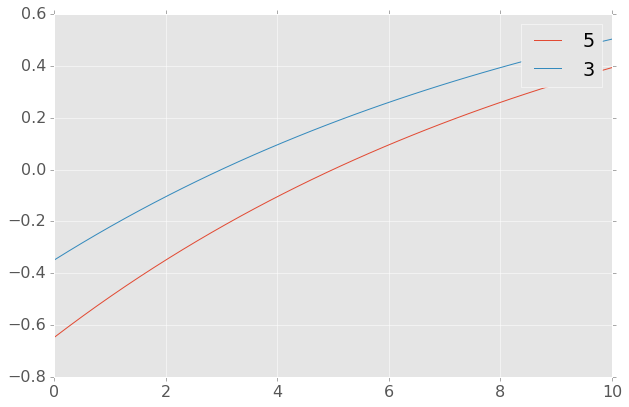

In [10]:
radius = linspace(0,10,40)
plt.plot(radius, 1 - np.exp(-0.1*(radius - 5)), label="5")
plt.plot(radius, 1 - np.exp(-0.1*(radius - 3)), label="3")
plt.legend()

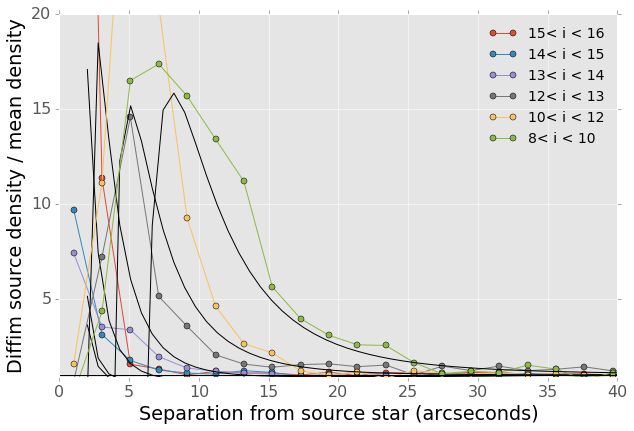

In [11]:
for bin_start,bin_end,curve_values in zip(density_bins[:-1], density_bins[1:], density_curves):
    plt.plot(radius_bin_centers, curve_values, 'o-',
             label="{:d}< i < {:d}".format(bin_end, bin_start))
    mag_bin_center = 0.5*(bin_start + bin_end)
    x = np.linspace(2,40,50)
    completeness_norm_scaling = 5 + -1.2*(mag_bin_center-10)
    completeness = 1 - np.exp(-0.1*(x - completeness_norm_scaling))
    
    radius_normalization = np.maximum(13-4*(mag_bin_center-12), 4)
    expected_sources = 1 + (x )**-4 / (radius_normalization**-4)

    plt.plot(x, expected_sources*completeness, 'k-', lw=1)

plt.axhline(1, color='k', ls='-', lw=1)
plt.ylim(0.9,20)
plt.xlim(0,40)
plt.xlabel("Separation from source star (arcseconds)")
plt.ylabel("Diffim source density / mean density")
plt.legend(frameon=False, loc="upper right", fontsize=14)

That doesn't work so well. Probably need to look at the actual footprints on the images. How precisely do we need to model this inner edge?